<a href="https://colab.research.google.com/github/Malachyiii/Pawpularity-PytorchLightning-SwinComputerVision/blob/main/Pawpularity_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install timm fastai
!pip install -U fastai
!pip install wandb --quiet
!pip install pytorch-lightning

In [2]:
#Downloading the Data
!wget -O data.zip "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/25383/2684322/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1641577717&Signature=WkjwoZIt1aYIF42c%2Bit9JVun1Hmr6nIuk3RG%2Bmyzp1Y6i8ZRgD8t6TnzhVHr7VFtzMtrqqZSj1h75OjCCIJvJCUWz%2BK66PnCFa%2FGKvyql5X1NKBXgh%2FR%2FQCPasJmFPjgk0Nh3JXbtmYn%2BHMi7MN5xUEd%2FdSb2CYt7k7Arf%2BwZ9sAARTL4bmwkwVguNaQUNHBrXUsYqLsOX9ZsoL0sH05So3jP5m30AfjR9%2BmRP4KKS5Aw07N3Fy4hQxZjoQCdB2DPsqOSjwVqjwWlKeYEw3zB4X4cwfSxGcTl%2FIme5ofe3QbY4oEx7tJ2iwn1YL3i42q6Yrv3ZoPlaJnP%2B0wKH14Wg%3D%3D&response-content-disposition=attachment%3B+filename%3Dpetfinder-pawpularity-score.zip"

--2022-01-05 20:07:30--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/25383/2684322/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1641577717&Signature=WkjwoZIt1aYIF42c%2Bit9JVun1Hmr6nIuk3RG%2Bmyzp1Y6i8ZRgD8t6TnzhVHr7VFtzMtrqqZSj1h75OjCCIJvJCUWz%2BK66PnCFa%2FGKvyql5X1NKBXgh%2FR%2FQCPasJmFPjgk0Nh3JXbtmYn%2BHMi7MN5xUEd%2FdSb2CYt7k7Arf%2BwZ9sAARTL4bmwkwVguNaQUNHBrXUsYqLsOX9ZsoL0sH05So3jP5m30AfjR9%2BmRP4KKS5Aw07N3Fy4hQxZjoQCdB2DPsqOSjwVqjwWlKeYEw3zB4X4cwfSxGcTl%2FIme5ofe3QbY4oEx7tJ2iwn1YL3i42q6Yrv3ZoPlaJnP%2B0wKH14Wg%3D%3D&response-content-disposition=attachment%3B+filename%3Dpetfinder-pawpularity-score.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1030728211 (983M) [application/zip]
Saving to: ‘data.zip’

da

In [3]:
! unzip -qq "data.zip" -d data

replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import math
import fastai
from fastai.vision.all import *

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms as T
from torchvision.io import read_image

import timm
from timm import create_model

import sklearn
from sklearn.model_selection import StratifiedKFold

In [2]:
#timm.list_models(pretrained=True)

In [3]:
class args:
  folder_name = Path('../content/data/')
  seed = 1212
  num_splits = 10
  batch_size = 32
  num_workers = 8
  imagesize = 224
  model_name = 'swin_small_patch4_window7_224'

In [4]:
df = pd.read_csv(args.folder_name/'train.csv')
df['filename'] = df['Id'].map(lambda x:str(args.folder_name/'train'/x)+'.jpg')

#feature_cols = [col for col in df.columns if col not in ['Id', 'Pawpularity', 'filename']]

In [5]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,filename
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../content/data/train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../content/data/train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../content/data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../content/data/train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../content/data/train/001dc955e10590d3ca4673f034feeef2.jpg


In [6]:
seed = args.seed

device = torch.device("cuda:0")

set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [7]:
df = df.drop(columns=['Id'])
df = df.sample(frac=1).reset_index(drop=True)
df['norm_score'] = df['Pawpularity']/100


num_bins = int(np.ceil(2*((len(df))**(1./3))))

df['bins'] = pd.cut(df['norm_score'], bins=num_bins, labels=False)


df['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=args.num_splits, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(df.index, df['bins'])):
    df.iloc[train_index, -1] = i

In [8]:
num_bins

43

In [9]:
def rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(torch.sigmoid(input.flatten()), target))

In [10]:
def get_data(fold):

    df_f = df.copy()
    df_f['is_valid'] = (df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(df_f, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=args.seed, #seed
                               fn_col='filename', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=args.batch_size, #pass in batch size
                               num_workers=args.num_workers,
                               item_tfms=Resize(args.imagesize), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), 
                                                          Saturation(), 
                                                          RandomErasing(p=.3, sh =.1, max_count = 2)])) #pass in batch_tfms
    
    return dls

In [11]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(df)//args.batch_size)

In [12]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model(args.model_name, pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=rmse).to_fp16()
    
    return learn

Fold 0 results


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,rmse,time
0,0.656757,0.648396,18.488203,02:52
1,0.653650,0.656089,19.394453,02:52
2,0.643700,0.644903,18.134598,02:52
3,0.627810,0.641200,17.511803,02:52
4,0.617208,0.642442,17.639309,02:53


Better model found at epoch 0 with valid_loss value: 0.6483960151672363.
Better model found at epoch 2 with valid_loss value: 0.6449026465415955.
Better model found at epoch 3 with valid_loss value: 0.6412000060081482.
Fold 1 results


epoch,train_loss,valid_loss,rmse,time
0,0.656111,0.661882,20.001593,02:52
1,0.667639,0.664634,20.436386,02:52
2,0.666330,0.664572,20.407045,02:52


Better model found at epoch 0 with valid_loss value: 0.6618818044662476.
No improvement since epoch 0: early stopping
Fold 2 results


epoch,train_loss,valid_loss,rmse,time
0,0.650302,0.642448,17.585859,02:52
1,0.646292,0.642504,17.593649,02:52
2,0.634964,0.642571,17.651806,02:52


Better model found at epoch 0 with valid_loss value: 0.6424477696418762.
No improvement since epoch 0: early stopping
Fold 3 results


epoch,train_loss,valid_loss,rmse,time
0,0.650016,0.645692,17.945250,02:52
1,0.644547,0.640778,17.314209,02:53
2,0.637340,0.639722,17.161999,02:52
3,0.624650,0.640399,17.259159,02:52
4,0.621264,0.641215,17.350500,02:53


Better model found at epoch 0 with valid_loss value: 0.6456915140151978.
Better model found at epoch 1 with valid_loss value: 0.640778124332428.
Better model found at epoch 2 with valid_loss value: 0.6397221684455872.
No improvement since epoch 2: early stopping
Fold 4 results


epoch,train_loss,valid_loss,rmse,time
0,0.650975,0.648640,18.573198,02:52
1,0.643851,0.644957,18.076437,02:52
2,0.637000,0.642188,17.735434,02:52
3,0.627975,0.642568,17.743656,02:52
4,0.622126,0.643144,17.799755,02:52


Better model found at epoch 0 with valid_loss value: 0.6486396193504333.
Better model found at epoch 1 with valid_loss value: 0.6449565887451172.
Better model found at epoch 2 with valid_loss value: 0.6421881914138794.
No improvement since epoch 2: early stopping
Fold 5 results


epoch,train_loss,valid_loss,rmse,time
0,0.651449,0.654647,19.075087,02:52
1,0.645195,0.651982,18.762003,02:52
2,0.632324,0.653896,18.807575,02:52
3,0.618386,0.659979,19.401709,02:52


Better model found at epoch 0 with valid_loss value: 0.6546469330787659.
Better model found at epoch 1 with valid_loss value: 0.6519817113876343.
No improvement since epoch 1: early stopping
Fold 6 results


epoch,train_loss,valid_loss,rmse,time
0,0.652113,0.647499,18.378370,02:52
1,0.642410,0.651190,18.725355,02:53
2,0.635210,0.642675,17.765516,02:52
3,0.623719,0.644006,17.900105,02:53
4,0.613573,0.645826,18.080303,02:52


Better model found at epoch 0 with valid_loss value: 0.6474987268447876.
Better model found at epoch 2 with valid_loss value: 0.6426745653152466.
No improvement since epoch 2: early stopping
Fold 7 results


epoch,train_loss,valid_loss,rmse,time
0,0.656851,0.653781,19.085749,02:52
1,0.668075,0.664622,20.264320,02:53
2,0.664924,0.664187,20.158131,02:52


Better model found at epoch 0 with valid_loss value: 0.6537806987762451.
No improvement since epoch 0: early stopping
Fold 8 results


epoch,train_loss,valid_loss,rmse,time
0,0.651151,0.648404,18.435083,02:52
1,0.646790,0.642554,17.683834,02:53
2,0.639192,0.641525,17.547735,02:52
3,0.635245,0.640079,17.351746,02:53
4,0.631442,0.640589,17.406761,02:53


Better model found at epoch 0 with valid_loss value: 0.6484039425849915.
Better model found at epoch 1 with valid_loss value: 0.6425537467002869.
Better model found at epoch 2 with valid_loss value: 0.6415248513221741.
Better model found at epoch 3 with valid_loss value: 0.6400787830352783.
Fold 9 results


epoch,train_loss,valid_loss,rmse,time
0,0.649536,0.646037,18.129625,02:52
1,0.643843,0.650300,18.594975,02:53
2,0.635717,0.642933,17.813345,02:53
3,0.627306,0.641919,17.645193,02:53
4,0.624099,0.642546,17.721855,02:53


Better model found at epoch 0 with valid_loss value: 0.6460371613502502.
Better model found at epoch 2 with valid_loss value: 0.642932653427124.
Better model found at epoch 3 with valid_loss value: 0.6419193148612976.


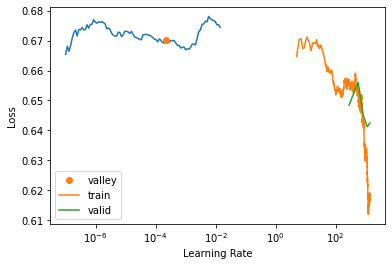

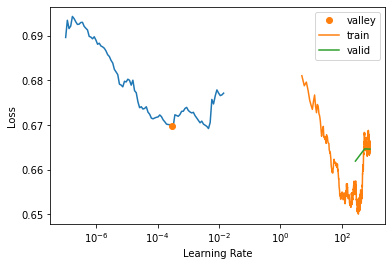

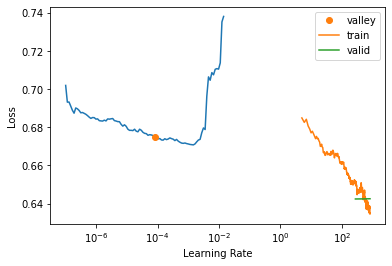

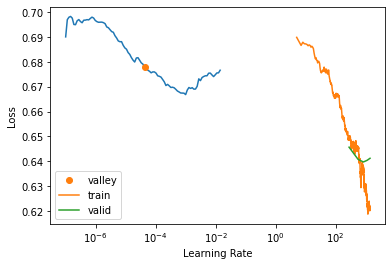

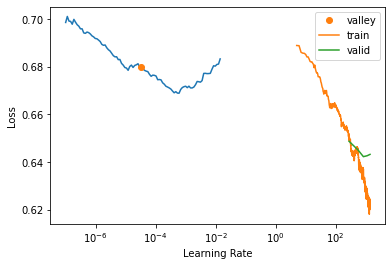

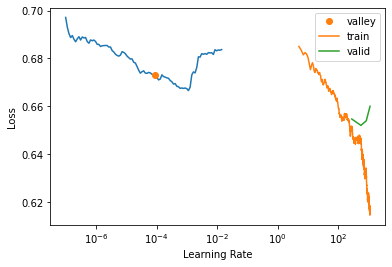

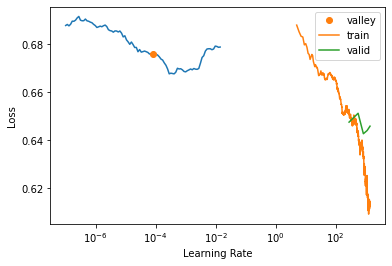

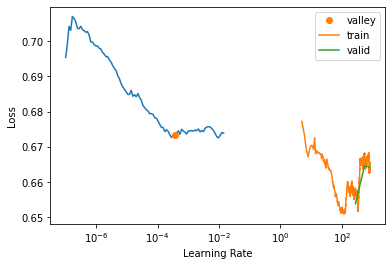

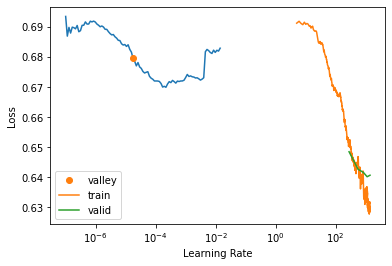

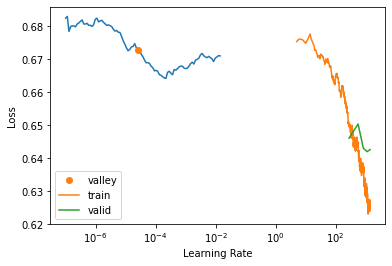

In [13]:
for i in range(args.num_splits):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    lr = learn.lr_find(end_lr=3e-2)

    learn.fit_one_cycle(5, lr.valley, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

# **Reference**
###  [Petfinder Pawpularity EDA & fastai starter 🐱🐶](https://www.kaggle.com/tanlikesmath/petfinder-pawpularity-eda-fastai-starter)
###  [Petfinder& fastai with DataAugmentation KFold 10](https://www.kaggle.com/bobber/petfinder-fastai-with-dataaugmentation-kfold-10)
###  [Lovely Doggo with Bonky (fastai &timm)](https://www.kaggle.com/warotjanpinitrat/lovely-doggo-with-bonky-fastai-timm)